# PyCPTv1.1
## Produce S2S (un)calibrated forecasts and assess associated skill 
## ECMWF/CFSv2-TRMM version

#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu) and Andrew W. Robertson (awr@iri.columbia.edu) 

#### Acknowledgements: 

Rémi Cousin (some key Ingrid code), James Doss-Gollin (some key Python functions)

#### Version log
* Latest changes on 12 Aug 2018 by AGM
* PyCPTv1.1:ECMWF/CFSv2-TRMM, modified by AGM on 1 Aug 2018
* Previous version: 17 Jul 2018, modified by AWR
* First iPython version (Jupyter Notebook) by AWR -- 24 Jun 2018
* First version (BASH) by AGM -- 12 Dec 2017 

#### Input:
* Predictor is rainfall from ECMWF (no realtime) or CFSv2 (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7)

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!
2. Weekly initializations available per month are used, concatenated.
3. The T coordinate has been faked, so CPT can deal with all the initializations.


### Namelist section
----------------------

In [1]:
########Model (choose between ECMWF and CFSv2)
model='ECMWF'

########Obs (choose between TRMM and CPC)
obs='TRMM'

########MOS method (choose between None and CCA)
MOS='CCA'

########Forecast date  
##-- If ECMWF, it needs to be a Monday or a Thursday! CFSv2: any day
mon='Jul' 	# Forecast month 
fyr=2018 	# Forecast year
fday=16 	# Forecast day  (Yesterday in CFSv2: real time)
training_season='Jul' ##'Jun-Aug' #for CFSv2

nwk= 4 # Number of weeks to process (leads)

########Switches:
force_download=False   #force download of data files, even if they already exist locally
# Rainfall frequency switch 
rainfall_frequency = True  #False gives total rainfall for forecast period

wetday_threshold = 3 #wet day threshold (mm) --only used if rainfall_frequency is True!
threshold_pctle = False    #False for threshold in mm


########Spatial domain for predictor
nla1=35 	# Northernmost latitude
sla1=-20 	# Southernmost latitude
wlo1=73 	# Westernmost longitude
elo1=155 	# Easternmost longitude
# Spatial domain for predictand
nla2=30 	# Northernmost latitude
sla2=-15 	# Southernmost latitude
wlo2=78 	# Westernmost longitude
elo2=150 	# Easternmost longitude

########Forecast lead interval
# Lists for looping over lead times
wk = [1,2,3,4,34]  # week-lead number label (week1, week2, week3-4)
day1 = [0,7,14,21,14]  # first lead day of target weeks 
day2 = [7,14,21,28,28]  # last lead day of target weeks 
wknam= ['Week 1','Week 2','Week 3','Week 4','Week 3-4']  #naming the weeks (for plots)

In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
workdir = '/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/'
# PATH to CPT root directory
cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/15.7.8/'

########Naming of output files
if rainfall_frequency:
    fprefix = 'RFREQ'
else:
    fprefix = 'PRCP'

########Model-dependent parameters
if model=='CFSv2':
    hstep = 3 # use all starts in the trainng period with this daily step between them (v5 used 7)
    nlag  = 3  # length of the lagged ensemble in days
    ntrain= 371  # Length of training period
elif model=='ECMWF':
    hstep = 0 # bogus but needed by functions (eliminate in the future)
    nlag  = 0 # bogus but needed by functions (eliminate in the future)
    ntrain= 160  # Length of training period
else:
    print ("Model option is invalid")
    
########Obs-dependent parameters
#if obs=='TRMM':
#    opref = 'RFREQ'
#elif obs=='CPC':
#
#else:
#    print ("Obs option is invalid")
    
########MOS-dependent parameters
if MOS=='None':
    mpref='noMOS'
elif MOS=='CCA':
    mpref='CCA'
else:
    print ("MOS option is invalid")

# S2S Database key
print("Present folder is:")
%cd $workdir
with open('.IRIDLAUTH') as file:
    authkey = file.read() 

Present folder is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF


### End of namelist section  (do not modify anything below this line)
----------------------

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
from pycpt_functions import *

In [4]:
if rainfall_frequency:
    print('Predictand is Rainfall Frequency; wet day threshold = '+str(wetday_threshold)+' mm')
else:
    print('Predictand is Rainfall Total (mm)')
    
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded...")

Predictand is Rainfall Frequency; wet day threshold = 3 mm
Creating working folders, if not already there...
Work directory is:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF
CPT environment loaded...


## Check if domains are ok --if you don't like them, go back to namelist and modify domains

Forecast date is 16 Jul 2018

     July 2018
Mo Tu We Th Fr Sa Su
                   1
 2  3  4  5  6  7  8
 9 10 11 12 13 14 15
16 17 18 19 20 21 22
23 24 25 26 27 28 29
30 31

    August 2018
Mo Tu We Th Fr Sa Su
       1  2  3  4  5
 6  7  8  9 10 11 12
13 14 15 16 17 18 19
20 21 22 23 24 25 26
27 28 29 30 31



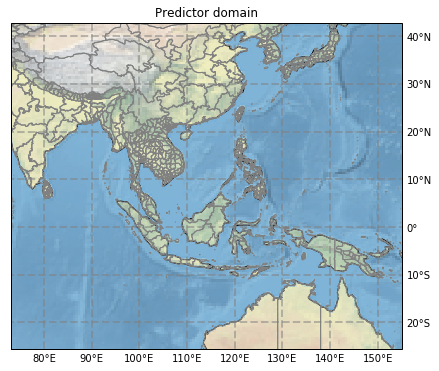

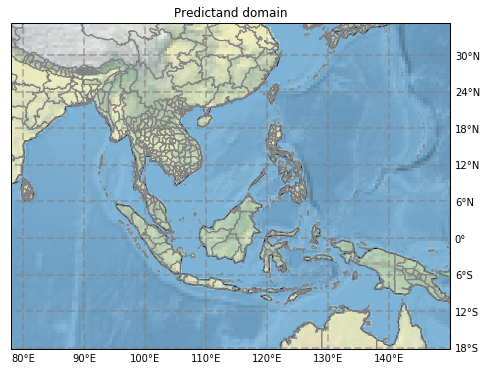

In [5]:
pltdomain(wlo1,elo1,nla1,sla1,'Predictor domain')
pltdomain(wlo2,elo2,nla2,sla2,'Predictand domain')

#Print calendars
print('Forecast date is '+str(fday)+' '+mon+' '+str(fyr))
print('')
c=calendar.TextCalendar(calendar.MONDAY)
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)))
print(c.formatmonth(fyr,list(calendar.month_abbr).index(mon)+1))

## Download data if necessary, and run CPT

In [5]:
for L in range(nwk):
   nday=day2[L]-day1[L]	# Length of target period (days) 
   print("New folder:")
   %cd $workdir/input

   PrepFiles(rainfall_frequency,wlo1, wlo2,elo1, elo2,sla1, sla2,nla1, nla2, day1[L], day2[L], fday, nday, fyr, mon, os, authkey, wk[L], wetday_threshold, nlag, training_season, hstep, model, force_download)
 
   print("New folder:")
   %cd $workdir/scripts

   CPTscript(mon,fday,wk[L],nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,training_season,ntrain,rainfall_frequency,MOS)

   print('Executing CPT for Week '+str(wk[L])+'... This might take a while...')
   os.system(cptdir+'CPT.x < params > CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt')
   print('----------------------------------------------')
   print('Week '+str(wk[L])+' calculations completed!')
   print('See output folder, and check scripts/CPT_stout_train_'+training_season+'_'+mon+'_'+str(fday)+'_wk'+str(wk[L])+'.txt for errors')
   print('----------------------------------------------')
   print('----------------------------------------------')



New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/input
Obs:rfreq file ready to go
----------------------------------------------
Hindcasts file ready to go
----------------------------------------------
Forecasts file ready to go
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/scripts
Executing CPT for Week 1... This might take a while...
----------------------------------------------
Week 1 calculations completed!
See output folder, and check scripts/CPT_stout_train_Jul_Jul_16_wk1.txt for errors
----------------------------------------------
----------------------------------------------
New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/input
Obs:rfreq file ready to go
----------------------------------------------
Hindcasts file ready to go
----------------------------------------------
Forecasts file ready to go
---------------------------------------------

## Skill maps

New folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/output


/Users/agmunoz/miniconda3/envs/wtype/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


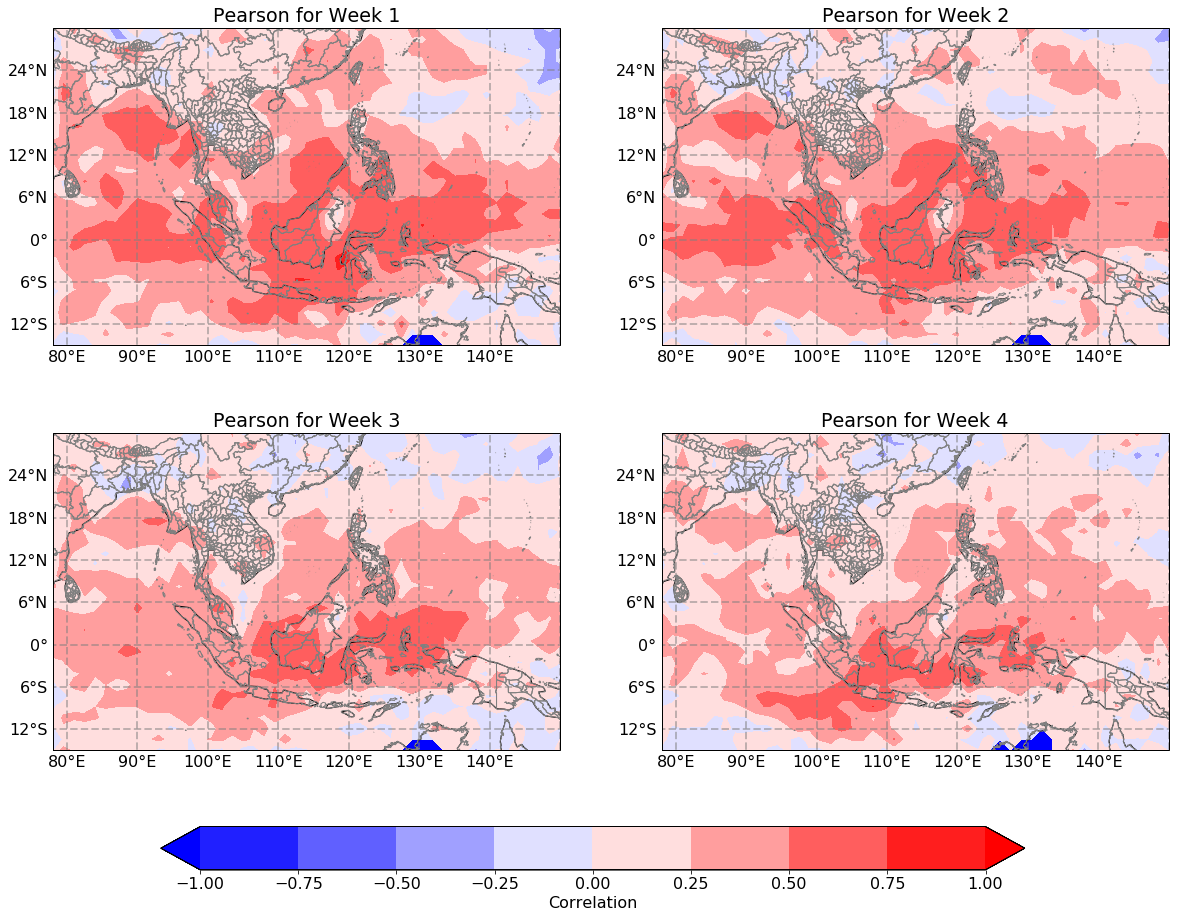

----------------------------------------------



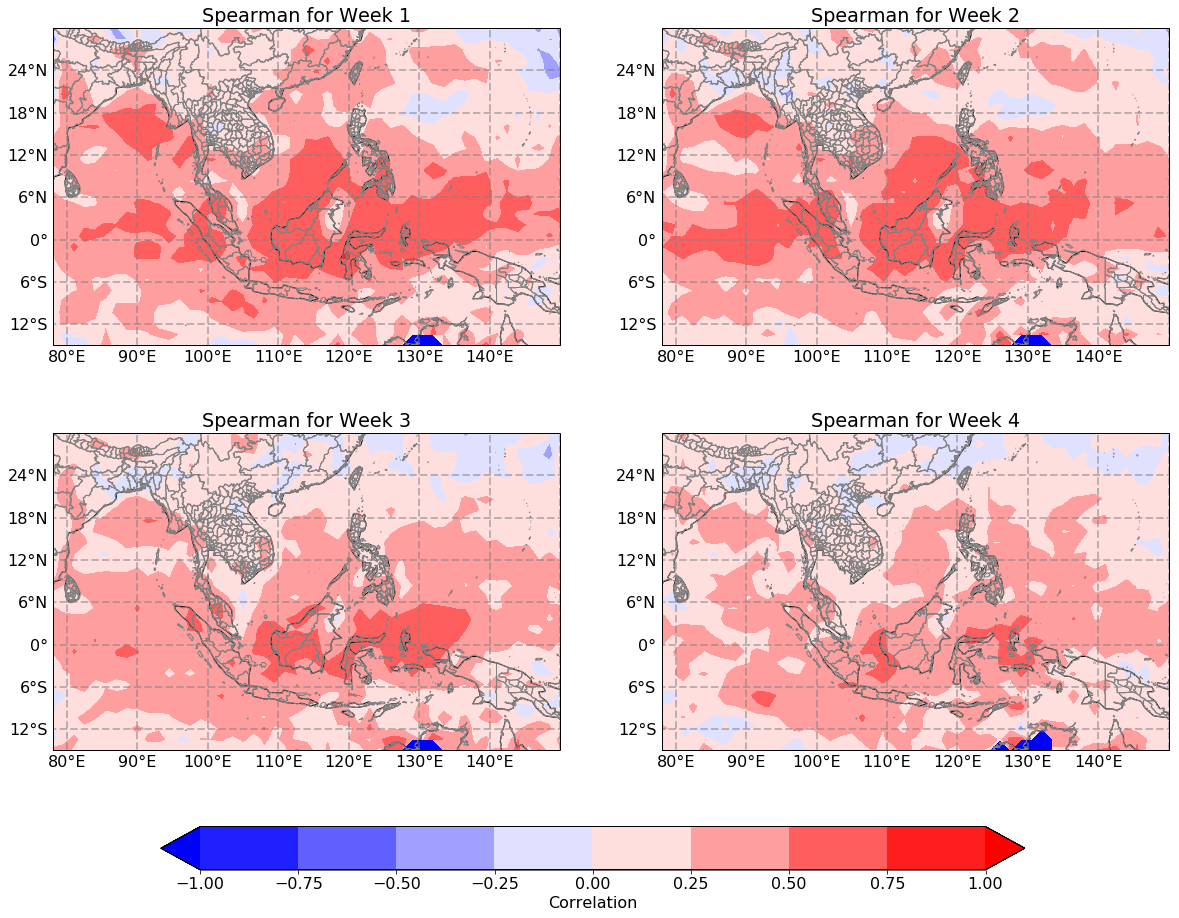

----------------------------------------------



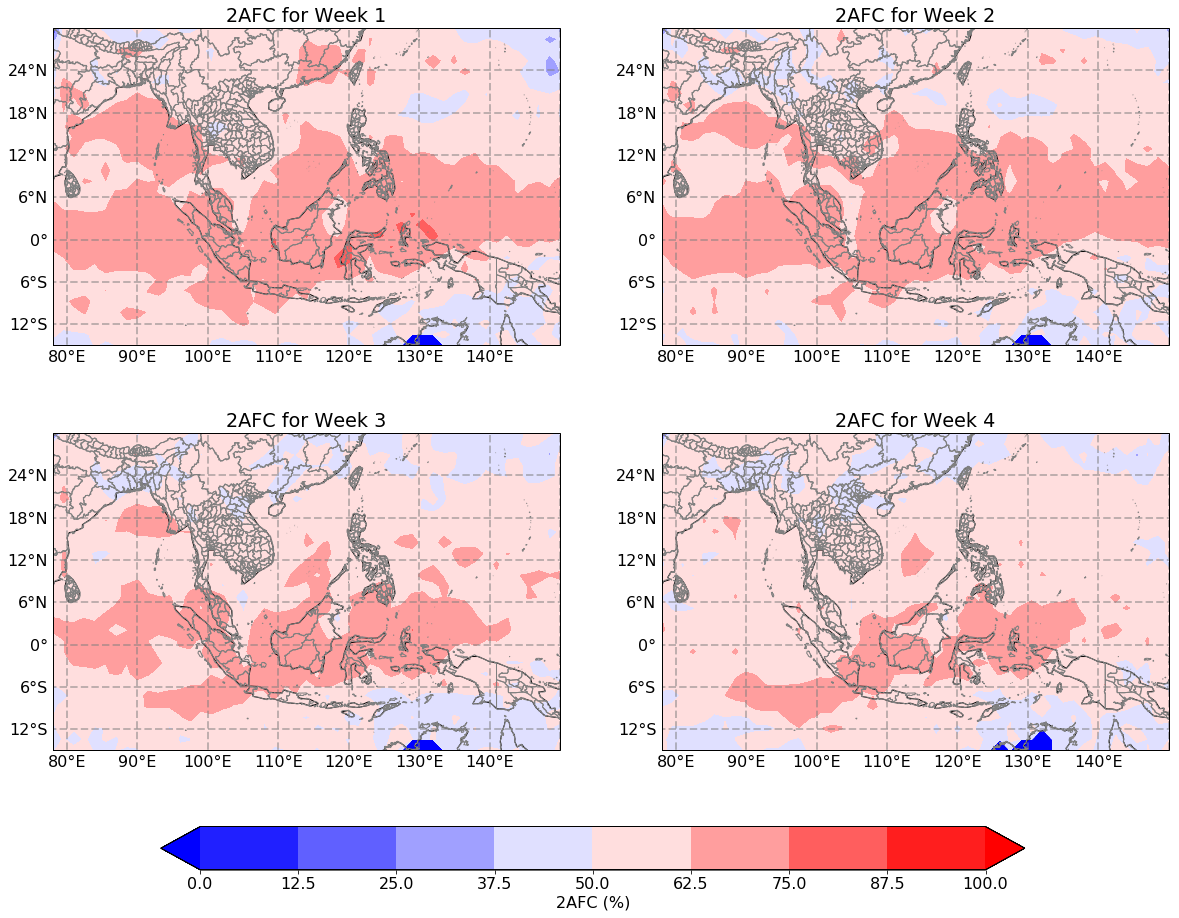

----------------------------------------------



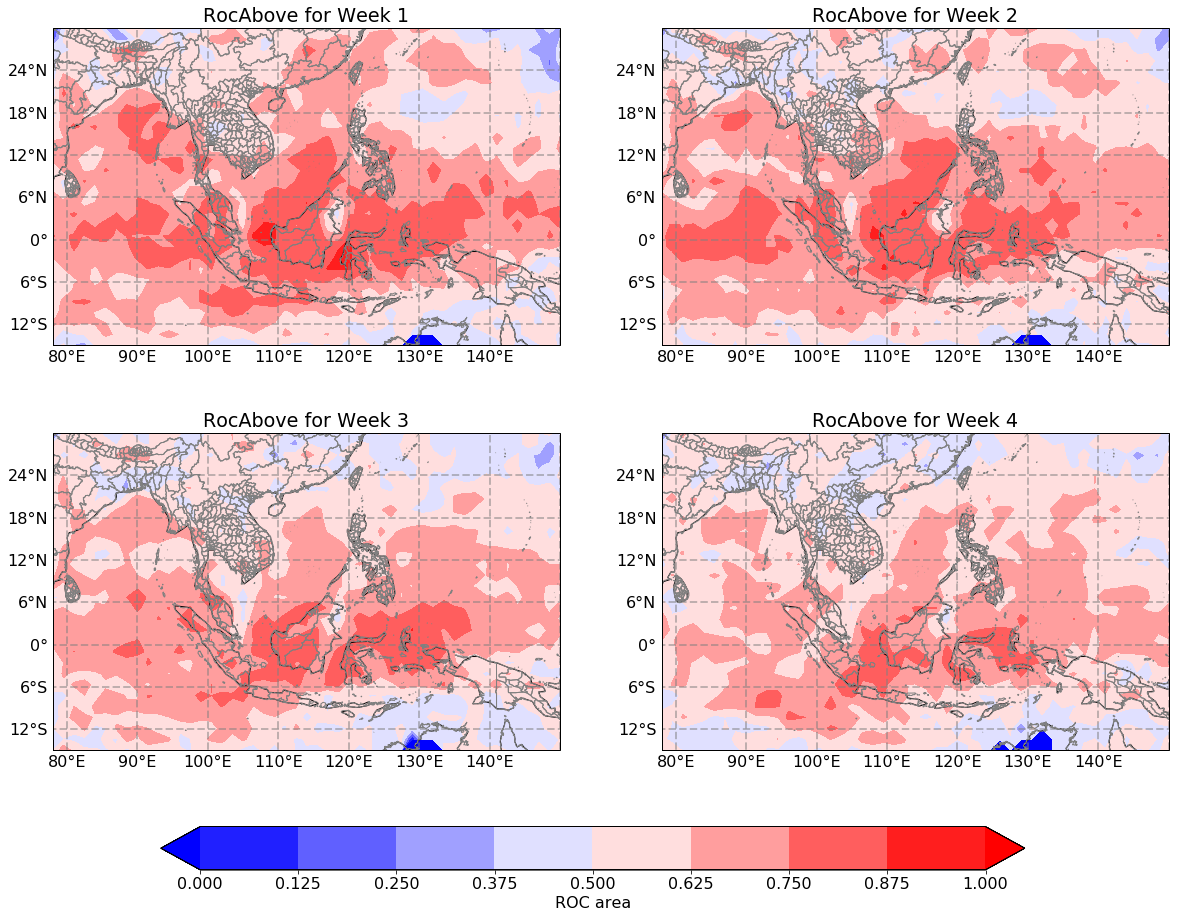

----------------------------------------------



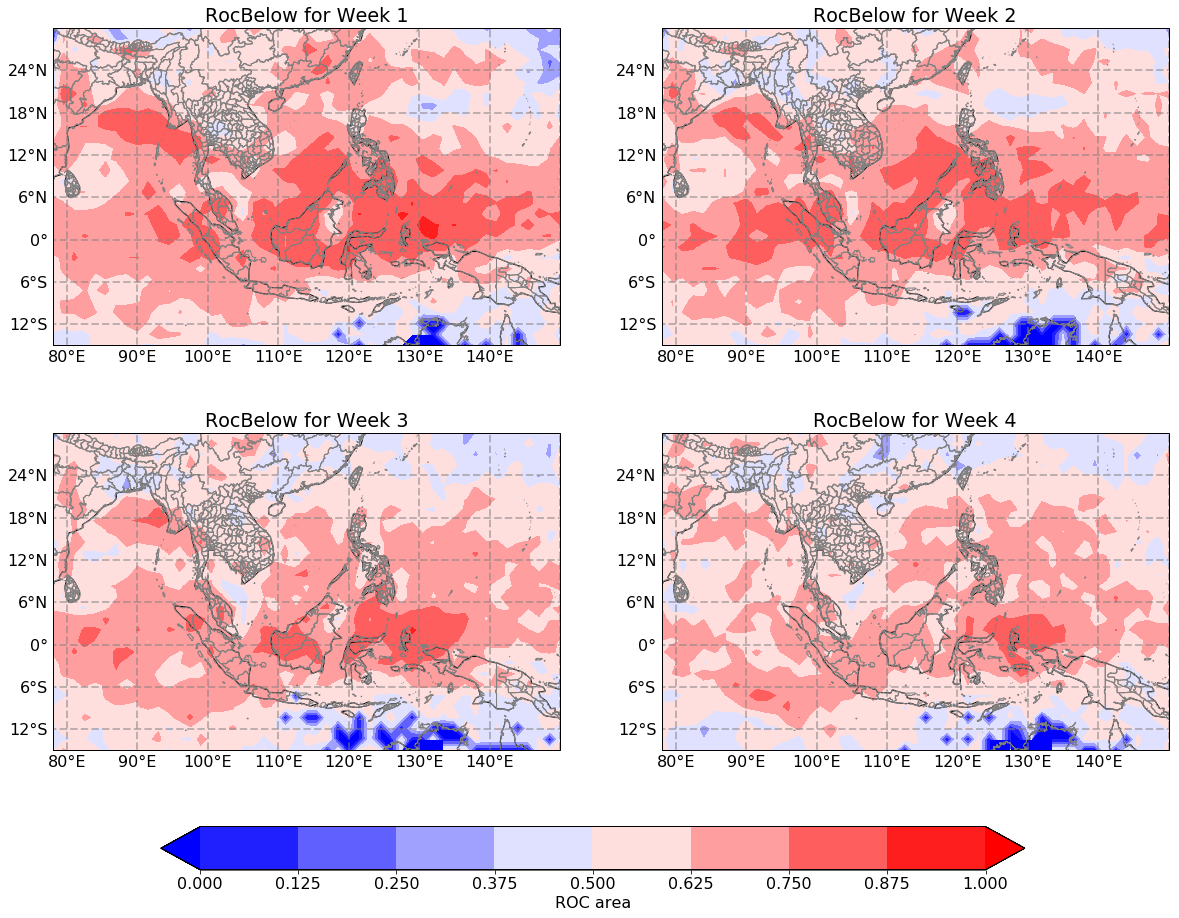

----------------------------------------------



In [5]:
print("New folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 16})
for ime in ('Pearson','Spearman','2AFC','RocAbove','RocBelow'):
    pltmap(ime,wlo2,elo2,nla2,sla2,fprefix,mpref,training_season, mon, fday, nwk)   
    plt.show()
    print('----------------------------------------------')
    print('')

## Forecast maps

Folder:
/Users/agmunoz/Documents/Angel/S2S_PredictionProject/4CPT/ECMWF/output
----------------------------------------------



/Users/agmunoz/miniconda3/envs/wtype/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


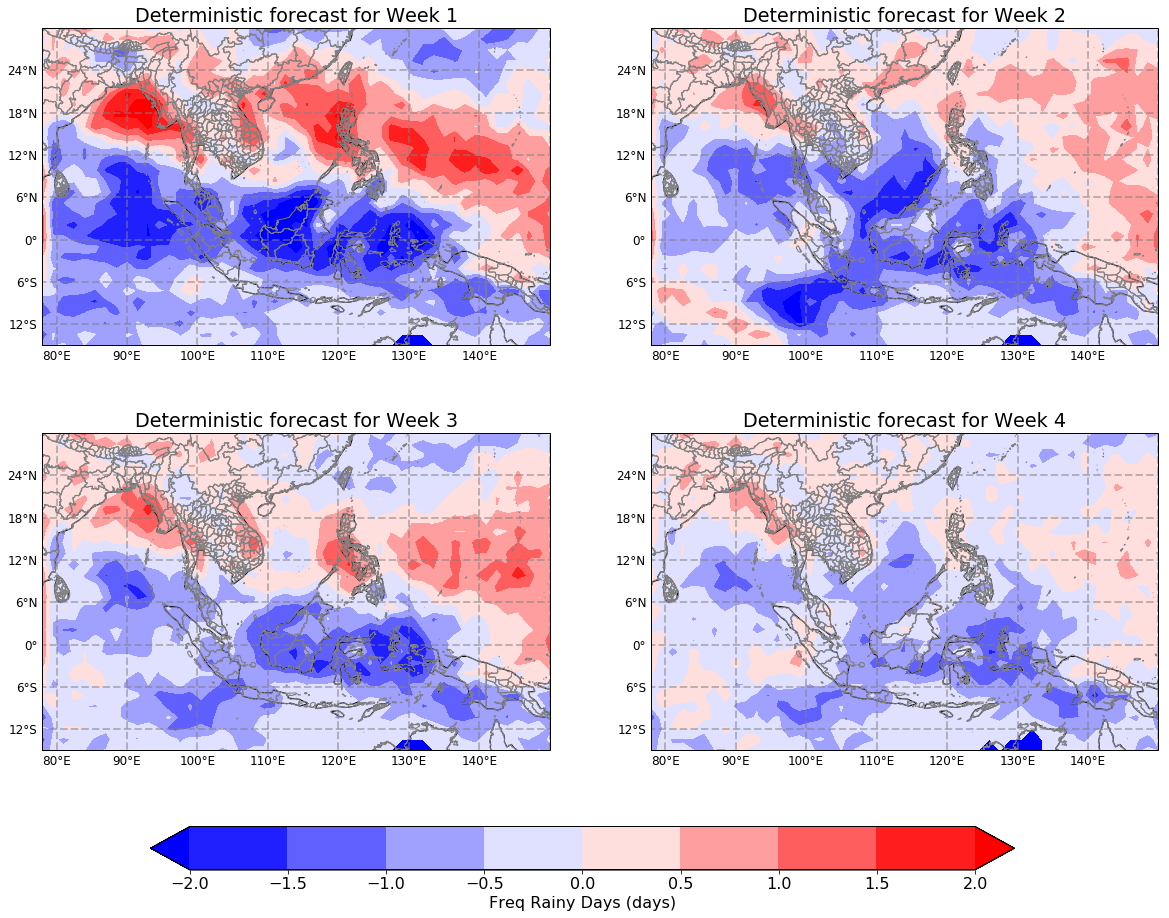

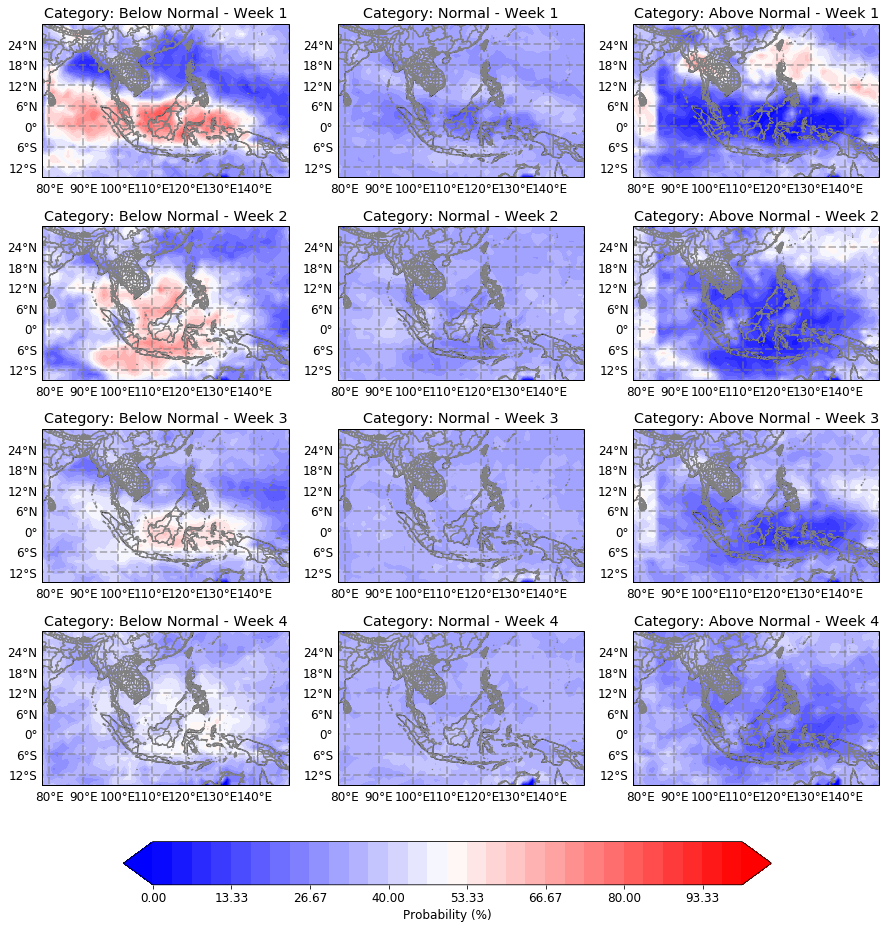

In [6]:
print("Folder:")
%cd $workdir/output

plt.rcParams.update({'font.size': 16})
pltmap(mpref+'FCST_V',wlo2,elo2,nla2,sla2,fprefix,mpref,training_season, mon, fday, nwk)
print('----------------------------------------------')
print('')
plt.rcParams.update({'font.size': 12})
pltmapProb(wlo2,elo2,nla2,sla2,fprefix,mpref,training_season, mon, fday, nwk)
plt.savefig("ProbFcst.pdf", dpi=150)